In [1]:
from __future__ import print_function
from datetime import datetime
import pandas
import numpy

In [2]:
import sys
sys.path.append('../shifted_beta_survival/')

In [3]:
from DataHandler import DataHandler
from ShiftedBeta import ShiftedBeta
from ShiftedBetaSurvival import ShiftedBetaSurvival

In [4]:
from new_test import make_raw_article_data, print_stats

In [5]:
data = pandas.read_csv('../data/data_2yr.csv')

total_size = 1000
index = numpy.arange(data.shape[0])
numpy.random.shuffle(index)
index = index[:total_size]

data = data.iloc[index]
data.index = numpy.arange(total_size)

In [6]:
names = list(data.keys())[1:-2]

x = data[names].values
y = data.values[:, -2].astype(int)
z = data.values[:, -1].astype(int)

names = ['bias'] + names

In [7]:
def article_data(copies=1, random=False):

    one_data = make_raw_article_data()
    
    data = one_data.copy()
    for i in range(1, copies):
        data = pandas.concat([data, one_data], axis=0)
        
    if random:
        data.insert(1, 'random', numpy.random.randint(0, 2, (data.shape[0], 1)))
        x = data[['category', 'random']].values
        names = ['bias', 'category', 'random']
    else:
        x = data[['category']].values
        names = ['bias', 'category']
        
    y = data.values[:, -2].astype(int)
    z = data.values[:, -1].astype(int)

    return x, y, z, names

In [27]:
x, y, z, names = article_data(copies=2, random=False)

In [29]:
sb = ShiftedBeta(verbose=True, gamma_alpha=1e-1, gamma_beta=1e-1)
sb.fit(y, z, x, restarts=1)

Starting Optimization with parameters:
        Samples: 4000
  gamma (alpha): 0.1
   gamma (beta): 0.1
           bias: True
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 | 0:00:02.97 |     6582.9829 |

Optimization completed:
             wa: [-0.40670837  0.05705799]
             wb: [ 1.331878   -1.16273679]
  LogLikelihood: 6582.98293456
   Reg. Penalty: 0.329452314792



In [30]:
print_stats(sb.alpha, sb.beta, [0], names)
for i in range(1, len(names)):
    print_stats(sb.alpha, sb.beta, [0, i], names)

bias_                | 0.66584, 3.7882, 0.14949
bias_category_       | 0.70493, 1.1843, 0.37313


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

In [32]:
s = sb.survival_function(x, 1, n_periods=13)

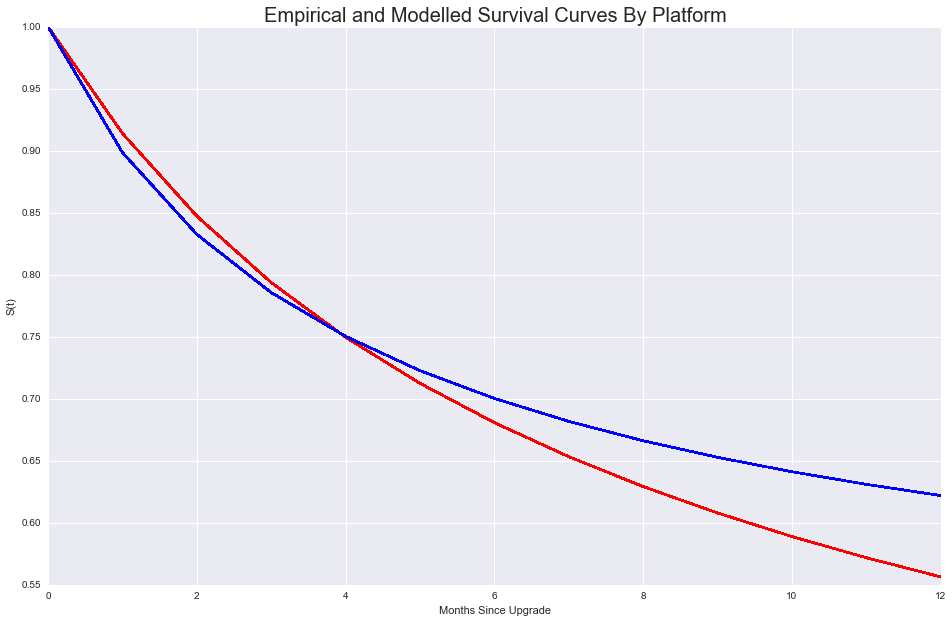

In [36]:
fig = plt.figure(figsize=(16, 10))
graph = fig.add_subplot(111)

for x_val, sf in zip(x[:2000], s[:2000]):
    if x_val[0] == 1:
        plt.plot(sf, alpha=0.5, color='blue')
    else:
        plt.plot(sf, alpha=0.5, color='red')


plt.title('Empirical and Modelled Survival Curves By Platform', fontsize=20)
plt.xlabel('Months Since Upgrade')
plt.ylabel('S(t)') 
#plt.legend()

In [34]:
sb.predict(x)

array([[ 0.66583834,  3.78815085],
       [ 0.66583834,  3.78815085],
       [ 0.66583834,  3.78815085],
       ..., 
       [ 0.70493451,  1.18428736],
       [ 0.70493451,  1.18428736],
       [ 0.70493451,  1.18428736]])

In [40]:
# Initialize list with t = 0 and t = 1 values
def calculate(alpha, beta, num_periods=12):
    
    p = [None, alpha / (alpha + beta)]
    s = [1., 1 - p[-1]]

    for t in range(2, num_periods + 1):

        # Compute latest p value and append
        p.append((beta + t - 2.) / (alpha + beta + t - 1.) * p[-1])

        # use the most recent appended p value to keep building s
        s.append(s[-1] - p[-1])

    # finish this...
    return p, s

In [43]:
_, s1 = calculate(sb.predict(x)[0, 0], sb.predict(x)[0, 1], num_periods=12)
_, s2 = calculate(sb.predict(x)[-1, 0], sb.predict(x)[-1, 1], num_periods=12)

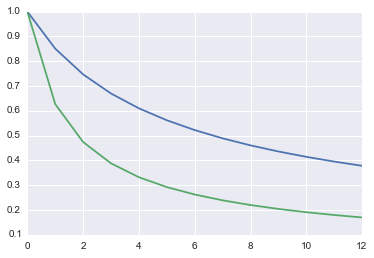

In [47]:
plt.plot(s1)
plt.plot(s2)

In [50]:
s[-1]

array([ 1.        ,  0.89859049,  0.83254379,  0.78561766,  0.75030473,
        0.72262326,  0.70025104,  0.68173587,  0.66611963,  0.65274278,
        0.64113537,  0.6309528 ,  0.62193622])